In [ ]:
import plotly.express as px
import pandas as pd
from urllib.request import urlopen
import json
import numpy as np

In [ ]:
data = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vQxxmZm6YG54VucQ9yRgWFQXtOI-RFJ5-sOLT93LpaYGYc-vabL9LOzzkRXX-LmSROTA7hOL1C327nZ/pub?gid=213261502&single=true&output=csv')
data.head()

In [ ]:
data.district.nunique()

In [ ]:
data[data.city == 'Moskva'].district.unique()

In [ ]:
data[data.district == 'Prostornaja 4kkv v Primorskom e4-komn. kv.']

In [ ]:
with open('D:/Загрузки/mo.geojson', 'r', encoding ='UTF-8') as f:
    msk_geojson = json.load(f)
msk_geojson

In [ ]:
# district_dict = {}
# for i in range(len(msk_geojson['features'])):
#     district_dict[msk_geojson['features'][i]['properties']['OKATO']] = [msk_geojson['features'][i]['properties']['NAME'],
#                                                                         msk_geojson['features'][i]['properties']['TYPE_MO']]
# district_dict
district_dict = {}
for i in range(len(msk_geojson['features'])):
    district_dict[msk_geojson['features'][i]['properties']['OKATO']] = [i+1,
                                                                        msk_geojson['features'][i]['properties']['TYPE_MO'],
                                                                        msk_geojson['features'][i]['properties']['NAME']]
district_dict

In [ ]:
from_gjson = pd.DataFrame.from_dict(district_dict, 
                                    orient = 'index', 
                                    columns = ['value','type','name']).reset_index()
from_gjson = from_gjson.drop(from_gjson[from_gjson['type'] == 'Поселение'].index, axis =0)
from_gjson.head()

In [ ]:
# state_geo = msk_geojson
# state_data = from_gjson

# m = folium.Map(location=[48, -102], zoom_start=3)

# folium.Choropleth(
#     geo_data=msk_geojson,
#     name="choropleth",
#     data=from_gjson,
#     columns=["index", "value"],
#     key_on="feature.properties.OKATO",
#     fill_color="YlGn",
#     fill_opacity=0.7,
#     line_opacity=0.2,
#     legend_name="Unemployment Rate (%)",
# ).add_to(m)

# folium.LayerControl().add_to(m)

# m

In [ ]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
#https://www.irn.ru/kvartiry/moskva/ceny-po-rayonam/?prn=1
with open('D:/Загрузки/html_prices.html', encoding = 'utf-8') as f:
    html = f.read()
    
soup = BeautifulSoup(html, "html.parser")

# Нахождение таблицы на странице
table = soup.find("table")

# Преобразование таблицы в датафрейм pandas
df = pd.read_html(str(table))[0]

# Вывод результата
#df['Рейтинг районов и метро Москвы по стоимости квартир, руб./кв.м.  (www.irn.ru)  Это средняя цена квадратного метра жилья по районам.  Подробнее']

In [ ]:
data_mean_priceperm2 = df['Рейтинг районов и метро Москвы по стоимости квартир, руб./кв.м.  (www.irn.ru)  Это средняя цена квадратного метра жилья по районам.  Подробнее'][['районы','Апр 23']]
data_mean_priceperm2

In [ ]:
new_data = data_mean_priceperm2['районы'].str.split(',', expand =True) \
                        .stack().reset_index(level=1,drop =True) \
                        .rename('районы')
data_mean_priceperm2 = pd.merge(data_mean_priceperm2.drop('районы', axis =1),new_data, left_index=True,right_index=True)
data_mean_priceperm2

In [ ]:
data_mean_priceperm2['Апр 23'] = data_mean_priceperm2['Апр 23'].str.replace(u'\xa0','').astype('int')
data_mean_priceperm2.rename(columns = {'Апр 23':'Цена за м2'}, inplace =True)

In [ ]:
data_mean_priceperm2['районы'] = data_mean_priceperm2['районы'].str.replace('ё','е')

In [ ]:
data_mean_priceperm2.loc[data_mean_priceperm2['районы'] =='Филевский парк','районы'] = 'Филевский Парк'
data_mean_priceperm2.loc[data_mean_priceperm2['районы'] =='Зеленоград:  Крюково','районы'] = 'Крюково'
data_mean_priceperm2.loc[data_mean_priceperm2['районы'] =='Марьина роща','районы'] = 'Марьина Роща'
data_mean_priceperm2.loc[data_mean_priceperm2['районы'] =='Соколиная гора','районы'] = 'Соколиная Гора'


In [ ]:
data_mean_priceperm2['районы'] = data_mean_priceperm2['районы'].str.lstrip()

In [ ]:
from_gjson.name = from_gjson.name.str.replace('ё','е')

In [ ]:
full_data = pd.merge(data_mean_priceperm2,from_gjson, left_on = 'районы',right_on ='name')
full_data.drop(['value','type'], inplace =True, axis =1)

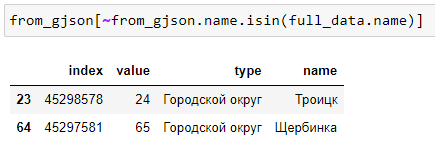

In [ ]:
new_data = pd.DataFrame(np.array([[101970,'Троицк','45298578','Троицк'],
                                  [146799,'Щербинка','45297581','Щербинка']]), 
                        columns = ['Цена за м2','районы','index','name'])
full_data = pd.concat([full_data,new_data],ignore_index=True)
full_data

In [ ]:
full_data.drop(['районы'], axis = 1, inplace =True)

In [ ]:
from_gjson[~from_gjson.name.isin(full_data.name)]

In [ ]:
data_mean_priceperm2[~data_mean_priceperm2['районы'].isin(full_data.name)]
# Жулебино уже есть
# Остоженка в Хамовниках
# Центр тоже
# Кожухово в Косино-Ухтомском

In [ ]:
full_data['Цена за м2'] = full_data['Цена за м2'].astype('int')

In [ ]:
full_data.rename({'index': 'OKATO'})

In [ ]:
full_data = full_data.rename(columns={'index':'OKATO'})
full_data.head()

In [ ]:
full_data.to_csv('geodata_msk.csv', sep = ';',index= False)

In [ ]:
import plotly.colors as colors
custom_color = colors.sequential.Plasma

fig = px.choropleth_mapbox(full_data, 
                           geojson=msk_geojson, 
                           locations='OKATO', 
                           color='Цена за м2',
                           color_continuous_scale=colors.sequential.Plasma,
                           featureidkey = 'properties.OKATO',
                           mapbox_style="carto-positron",
                           zoom=8.5, 
                           center = {"lat": 55.75, "lon":37.61},
                           opacity=0.2,
                           range_color=(full_data['Цена за м2'].min(), full_data['Цена за м2'].max()),
                           labels={'Цена за м2':'Цена квадратного метра жилья'}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show(render = 'notebook')

In [ ]:
data.head()